In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
!pip install --upgrade reedsolo
import reedsolo as rs

(21, 21)


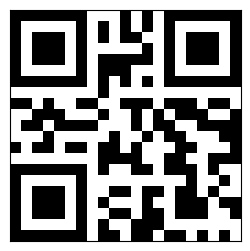

In [ ]:
_, img3 = cv2.threshold(cv2.imread("/content/image1.jpg", cv2.IMREAD_GRAYSCALE), 128, 255, cv2.THRESH_BINARY);

start_row = -1
start_col = -1
end_row = -1
end_col = -1

for row_index, row in enumerate(img3):
    for pixel in row:
        if pixel != 255:
            start_row = row_index
            break
    if start_row != -1:
        break

for row_index, row in enumerate(img3[::-1]):
    for pixel in row:
        if pixel != 255:
            end_row = img3.shape[0] - row_index
            break
    if end_row != -1:
        break

for col_index, col in enumerate(cv2.transpose(img3)):
    for pixel in col:
        if pixel != 255:
            start_col = col_index
            break
    if start_col != -1:
        break

for col_index, col in enumerate(cv2.transpose(img3)[::-1]):
    for pixel in col:
        if pixel != 255:
            end_col = img3.shape[1] - col_index
            break
    if end_col != -1:
        break

img3_no_quiet_zone = img3[start_row:end_row, start_col:end_col]

# Alternative method to get the grid directly
# I directly resize it to 21x21 and use something like the replacement downscaling geometric transformation
# So for each collection of pixels, only one pixel survives, and since this is a perfect test case, it works
# In non-perfect test cases, you'd have needed to do some more steps to ensure correct replacement is done
img3_21x21_grid = cv2.resize(img3_no_quiet_zone, (21, 21), interpolation=cv2.INTER_AREA) // 255

fig = plt.figure(figsize=(3, 3));
plt.xticks([], []);
plt.yticks([], []);
plt.imshow(img3_21x21_grid, cmap='gray');
print(img3_21x21_grid.shape)

In [ ]:
img3_21x21_grid_inv = 1 - img3_21x21_grid
print(img3_21x21_grid_inv)

[[1 1 1 1 1 1 1 0 0 0 1 0 1 0 1 1 1 1 1 1 1]
 [1 0 0 0 0 0 1 0 1 0 1 0 1 0 1 0 0 0 0 0 1]
 [1 0 1 1 1 0 1 0 1 0 1 1 0 0 1 0 1 1 1 0 1]
 [1 0 1 1 1 0 1 0 0 0 0 0 1 0 1 0 1 1 1 0 1]
 [1 0 1 1 1 0 1 0 1 1 1 1 1 0 1 0 1 1 1 0 1]
 [1 0 0 0 0 0 1 0 1 1 1 0 0 0 1 0 0 0 0 0 1]
 [1 1 1 1 1 1 1 0 1 0 1 0 1 0 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 1 0 1 0 0 1 1 0 0 1 1 1 0 1 1 1 0 1 1 0]
 [0 0 1 1 1 0 0 0 1 0 0 1 0 1 0 1 1 1 0 0 1]
 [0 1 1 0 1 1 1 1 0 0 0 1 0 1 1 0 0 1 1 1 1]
 [0 0 0 1 0 0 0 0 0 1 0 0 1 0 1 1 0 0 0 1 1]
 [1 0 1 1 0 1 1 0 1 1 0 1 0 0 0 1 1 0 0 0 1]
 [0 0 0 0 0 0 0 0 1 1 1 1 0 0 1 1 0 0 1 1 1]
 [1 1 1 1 1 1 1 0 1 0 0 1 1 0 1 1 1 0 1 0 0]
 [1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 1 0]
 [1 0 1 1 1 0 1 0 0 1 1 0 1 1 0 1 1 0 1 0 0]
 [1 0 1 1 1 0 1 0 1 0 0 0 1 0 0 1 1 1 0 1 1]
 [1 0 1 1 1 0 1 0 0 1 1 0 1 1 0 1 1 1 0 0 1]
 [1 0 0 0 0 0 1 0 1 0 0 1 1 1 0 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 0 1 1 0 1 1 0 1 1 0 1 0 1 0]]


In [ ]:
ecl = img3_21x21_grid_inv[8, 0:2]
mask = img3_21x21_grid_inv[8, 2:5]
# I don't care about FEC because I know this is a perfect test case
# However, you! should care (the FEC is what tells you whether the format bits are correct or not)
# I will leave it up to you to check for their correctness via decoding or a lookup table
# Since this time I won't demonstrate the FEC concept, I don't need to apply the FEC mask
# Thus, these are our ECL and MASK values:
print(ecl, mask)
# Remember, regarding the ECL value, we choose from the following:
# Level L (Low)         [11]	7%  of data bytes can be restored.
# Level M (Medium)      [10]	15% of data bytes can be restored.
# Level Q (Quartile)    [01]	25% of data bytes can be restored.
# Level H (High)        [00]	30% of data bytes can be restored.

[1 1] [0 1 0]


In [ ]:
# Dictionary of all masks and their equivalent formulae
# P.S. I modified them to account for that I skipped the FEC mask part above
# If you will do it, do not XOR the mask if you wish to use this MASKS table
MASKS = {
    "000": lambda i, j: (i * j) % 2 + (i * j) % 3 == 0,
    "001": lambda i, j: (i // 2 + j // 3) % 2 == 0,
    "010": lambda i, j: ((i + j) % 2 + (i * j) % 3) % 2 == 0,
    "011": lambda i, j: ((i * j) % 2 + (i * j) % 3) % 2 == 0,
    "100": lambda i, j: i % 2 == 0,
    "101": lambda i, j: (i + j) % 2 == 0,
    "110": lambda i, j: (i + j) % 3 == 0,
    "111": lambda i, j: j % 3 == 0,
}
# Enum for the different directions of reading blocks in the QR code
# The number indicates how many bytes are in this block
UP8, UP4, DOWN8, DOWN4, CW8, CCW8 = range(6)

In [ ]:

def apply_mask_general(data_start_i, data_start_j, data, mask, direction):
    print(f"Applying mask with start indices: {data_start_i}, {data_start_j}, direction: {direction}")
    result = []
    row_offsets = []
    col_offsets = []
    mask_str = ''.join([str(c) for c in mask])
    if (direction in [UP8, UP4]):
        row_offsets = [0,  0, -1, -1, -2, -2, -3, -3]
        col_offsets = [0, -1,  0, -1,  0, -1,  0, -1]
    if (direction in [DOWN8, DOWN4]):
        row_offsets = [0,  0,  1,  1,  2,  2,  3,  3]
        col_offsets = [0, -1,  0, -1,  0, -1,  0, -1]
    if (direction == CW8):
        row_offsets = [0,  0,  1,  1,  1,  1,  0,  0]
        col_offsets = [0, -1,  0, -1, -2, -3, -2, -3]
    if (direction == CCW8):
        row_offsets = [0,  0, -1, -1, -1, -1,  0,  0]
        col_offsets = [0, -1,  0, -1, -2, -3, -2, -3]
    for i, j in zip(row_offsets, col_offsets):
        cell_bit = bool(data[data_start_i+i, data_start_j+j])
        mask_bit = MASKS[mask_str](data_start_i+i, data_start_j+j)
        print(f"Cell bit: {cell_bit}, Mask bit: {mask_bit}, Mask: {mask_str}")
        # Modules corresponding to the dark areas of the mask are inverted.
        result.append(int(not cell_bit if mask_bit else cell_bit))
    print(f"Result: {result}")
    return result[:4] if direction in [UP4, DOWN4] else result


In [ ]:
enc_bits = apply_mask_general(21-1, 21-1, img3_21x21_grid_inv, mask, UP8)[:4]
print(enc_bits)
# 0001	Numeric encoding (10 bits per 3 digits)
# 0010	Alphanumeric encoding (11 bits per 2 characters)
# 0100	Byte encoding (8 bits per character)
# 1000	Kanji encoding (13 bits per character)
# ...

Applying mask with start indices: 20, 20, direction: 0
Cell bit: False, Mask bit: False, Mask: 010
Cell bit: True, Mask bit: False, Mask: 010
Cell bit: False, Mask bit: False, Mask: 010
Cell bit: False, Mask bit: False, Mask: 010
Cell bit: True, Mask bit: True, Mask: 010
Cell bit: False, Mask bit: False, Mask: 010
Cell bit: True, Mask bit: True, Mask: 010
Cell bit: True, Mask bit: True, Mask: 010
Result: [0, 1, 0, 0, 0, 0, 0, 0]
[0, 1, 0, 0]


In [ ]:
len_bits = apply_mask_general(21-3, 21-1, img3_21x21_grid_inv, mask, UP8)
len_int = int(''.join([str(bit) for bit in len_bits]), 2)
print(f'{len_bits} = {len_int} data symbols, each consisting of 8 bits')

Applying mask with start indices: 18, 20, direction: 0
Cell bit: True, Mask bit: True, Mask: 010
Cell bit: False, Mask bit: False, Mask: 010
Cell bit: True, Mask bit: True, Mask: 010
Cell bit: True, Mask bit: True, Mask: 010
Cell bit: False, Mask bit: True, Mask: 010
Cell bit: False, Mask bit: True, Mask: 010
Cell bit: False, Mask bit: False, Mask: 010
Cell bit: True, Mask bit: True, Mask: 010
Result: [0, 0, 0, 0, 1, 1, 0, 0]
[0, 0, 0, 0, 1, 1, 0, 0] = 12 data symbols, each consisting of 8 bits


In [ ]:
block_starting_indices = [
    [21-7,  21-1,  UP8],
    [21-11, 21-1,  CCW8],
    [21-10, 21-3,  DOWN8],
    [21-6,  21-3,  DOWN8],
    [21-2,  21-3,  CW8],
    [21-3,  21-5,  UP8],
    [21-7,  21-5,  UP8],
    [21-11, 21-5,  CCW8],
    [21-10, 21-7,  DOWN8],
    [21-6,  21-7,  DOWN8],
    [21-2,  21-7,  CW8],
    [21-3,  21-9,  UP8],
    [21-7,  21-9,  UP8],
    [21-11, 21-9,  UP8],
    [21-16, 21-9,  UP8],
    [21-20, 21-9,  CCW8],
    [21-19, 21-11, DOWN8],
    [21-14, 21-11, DOWN4],  # Special 4-byte block, reserved for END (if exists!)
    [21-12, 21-11, DOWN8],
    [21-8,  21-11, DOWN8],
    [21-4,  21-11, DOWN8],
    [21-9,  21-13, UP8],
    [21-12, 21-16, DOWN8],
    [21-9,  21-18, UP8],
    [21-12, 21-20, DOWN8],
]

In [ ]:
message_bits = []
message_bits.extend(enc_bits)
message_bits.extend(len_bits)
print(f"Initial message bits: {message_bits}")
# Let me re-format this for better readability :)
# First, let's read the data bytes, starting from the very first byte after enc and len
byte_index = 0
for _ in range(len_int):
    start_i, start_j, dir = block_starting_indices[byte_index]
    print(f"Start indices: {start_i}, {start_j}, direction: {dir}")
    bits = apply_mask_general(start_i, start_j, img3_21x21_grid_inv, mask, dir)
    message_bits.extend(bits)
    bit_string = ''.join([str(bit) for bit in bits])
    alpha_char = chr(int(bit_string, 2))
    print(f'Bit string: {bit_string} (={int(bit_string, 2):03d}) = {alpha_char}')
    byte_index += 1
print(f"Final message bits: {message_bits}")


Initial message bits: [0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0]
Start indices: 14, 20, direction: 0
Applying mask with start indices: 14, 20, direction: 0
Cell bit: False, Mask bit: False, Mask: 010
Cell bit: False, Mask bit: False, Mask: 010
Cell bit: True, Mask bit: False, Mask: 010
Cell bit: True, Mask bit: False, Mask: 010
Cell bit: True, Mask bit: True, Mask: 010
Cell bit: False, Mask bit: False, Mask: 010
Cell bit: True, Mask bit: True, Mask: 010
Cell bit: True, Mask bit: True, Mask: 010
Result: [0, 0, 1, 1, 0, 0, 0, 0]
Bit string: 00110000 (=048) = 0
Start indices: 10, 20, direction: 5
Applying mask with start indices: 10, 20, direction: 5
Cell bit: True, Mask bit: True, Mask: 010
Cell bit: True, Mask bit: True, Mask: 010
Cell bit: True, Mask bit: False, Mask: 010
Cell bit: False, Mask bit: True, Mask: 010
Cell bit: False, Mask bit: False, Mask: 010
Cell bit: True, Mask bit: True, Mask: 010
Cell bit: True, Mask bit: True, Mask: 010
Cell bit: True, Mask bit: False, Mask: 010
Result: [

In [ ]:
# After finishing all the characters, the next 4 bits are expected to be '0000'
start_i, start_j, dir = block_starting_indices[byte_index]
print(f"Start indices: {start_i}, {start_j}, direction: {dir}")
bits = apply_mask_general(start_i, start_j, img3_21x21_grid_inv, mask, dir)
message_bits.extend(bits)
print(f"Bits: {bits}")
byte_index += 1
print(f"Byte index: {byte_index}")


Start indices: 14, 12, direction: 0
Applying mask with start indices: 14, 12, direction: 0
Cell bit: True, Mask bit: True, Mask: 010
Cell bit: True, Mask bit: True, Mask: 010
Cell bit: False, Mask bit: False, Mask: 010
Cell bit: True, Mask bit: True, Mask: 010
Cell bit: False, Mask bit: True, Mask: 010
Cell bit: True, Mask bit: False, Mask: 010
Cell bit: True, Mask bit: False, Mask: 010
Cell bit: False, Mask bit: False, Mask: 010
Result: [0, 0, 0, 0, 1, 1, 1, 0]
Bits: [0, 0, 0, 0, 1, 1, 1, 0]
Byte index: 13


In [ ]:
# Let's see what the bytes that follow look like
# There supposedly remain 25-2=23 bytes to be read
for _ in range(23):
    start_i, start_j, dir = block_starting_indices[byte_index]
    print(f"Start indices: {start_i}, {start_j}, direction: {dir}")
    bits = apply_mask_general(start_i, start_j, img3_21x21_grid_inv, mask, dir)
    message_bits.extend(bits)
    bit_string = ''.join([str(bit) for bit in bits])
    alpha_char = chr(int(bit_string, 2))
    print(f'Bit string: {bit_string} (={int(bit_string, 2):03d}) = {alpha_char}')
    byte_index += 1
    print(f"Byte index: {byte_index}")


IndexError: list index out of range

In [ ]:
# For every 8 bits in the extracted message, convert to a byte
message_bytes = [int("".join(map(str, message_bits[i:i+8])), 2) for i in range(0, len(message_bits), 8)]
print(f"Message bytes: {message_bytes}")

# Create the Reed-Solomon Codec for 7 ECC symbols (again, this is L)
rsc = rs.RSCodec(nsym=7)

# Decode the bytes with the 7-ECC RS Codec
message_decoded = rsc.decode(message_bytes)
print(f"Decoded message: {message_decoded}")

rsc.maxerrata(verbose=True)

# In order to extract the actual data, need to convert back to bits
# Then take as many bytes as indicated by the message length indicator
# That is AFTER removing the first 12 bytes (of enc and len)
data_bits = bin(int.from_bytes(message_decoded[0], byteorder='big'))[13:13+len_int*8]
print(f"Data bits: {data_bits}")

# Now convert back to bytes and print it lol
data_bytes = int(data_bits, 2).to_bytes((len(data_bits)+7)//8, 'big')
print(f'Data in message = "{data_bytes.decode(encoding="iso-8859-1")}"')
print(f'Data should be... "a"')


Message bytes: [64, 195, 3, 18, 212, 118, 246, 246, 66, 6, 166, 246, 34, 16, 236, 17, 236, 17, 236, 67, 39, 95, 59, 243, 145, 152, 152]
Decoded message: (bytearray(b'@\xc3\x03\x12\xd4v\xf6\xf6B\x06\xa6\xf6"\x10\xec\x11\xec\x11\xecC'), bytearray(b'@\xc3\x03\x12\xd4v\xf6\xf6B\x06\xa6\xf6"\x10\xec\x11\xec\x11\xecC\'_;\xf3\x91\x98\x00'), bytearray(b'\x1a'))
This codec can correct up to 3 errors and 7 erasures independently
Data bits: 001100000011000100101101010001110110111101101111011001000010000001101010011011110110001000100001
Data in message = "01-Good job!"
Data should be... "a"
